In [1]:
import pandas as pd
import os
from datetime import datetime, timedelta, timezone
import seaborn as sns; sns.set_theme('paper')
import matplotlib.pyplot as plt
from model import get_model
from skimage.measure import block_reduce
import numpy as np
from tqdm import tqdm


def max_pooling(arr, sampling):
    return block_reduce(arr, (sampling, ), np.max)

def dt_to_ms(dt):
    epoch = datetime.utcfromtimestamp(0)
    delta = dt - epoch
    return int(delta.total_seconds() * 1000)



def normalize_data(data):
    """inplace operation"""
    def minimum(data):
        return min(min(data, key=lambda x: min(x)))

    def maximum(data):
        return max(max(data, key=lambda x: max(x)))

    mini = minimum(data)
    for subarr in data:
        subarr -= mini
    maxi = maximum(data)
    for subarr in data:
        subarr /= maxi

2024-04-23 17:40:58.102511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_raw1 = pd.read_csv('./Data/In-wild/P102/raw_102_2018-07-05t16_12_26z_ecg_lead_ii.csv')
df_raw2 = pd.read_csv('./Data/In-wild/P102/raw_102_2018-07-06t12_54_40z_ecg_lead_ii.csv')
df_ema = pd.read_csv('./Data/In-wild/P102/EMA.csv')

In [3]:
def get_full_data(df_ema, dataframes, delta):
    delta = int(delta * 60_000)
    df_ema = df_ema[['BinaryStress', 'LikertStress','WorriedStress', 'UTC_Time']].copy()
    emas = []
    data = []
    for column in df_ema.columns[:-1]:
        df_ema[column] = (df_ema[column] >= df_ema[column].mean()).astype(int)
    for idx, row in df_ema.iterrows():
        timestamp = row['UTC_Time']
        end_datetime_object = dt_to_ms(datetime.strptime(timestamp, '%m/%d/%Y %H:%M'))
        for df_raw in dataframes:
            sliced_df = df_raw[df_raw['Timestamp (ms)'].between(end_datetime_object-delta, end_datetime_object)]
            if len(sliced_df):
                break
        if not len(sliced_df):
            continue
        sliced_sig = sliced_df['Sample (V)'].to_numpy()
        sliced_sig = max_pooling(sliced_sig, 2)
        emas.append((row['BinaryStress'], row['LikertStress'], row['WorriedStress']))
        data.append(sliced_sig)
    normalize_data(data)
    return data, emas


In [4]:
exclude = ['P101', 'P107', 'P111', 'P112', 'P113', 'P114']

In [5]:
clf = get_model(None)
clf.load_weights('./chkpts/v4(2)/')

2024-04-23 17:41:01.701280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def segment_generator(data, num):
    n = len(data)
    num = len(data) // 15000
    num += 1
    for i in range(num):
        yield data[i*15_000 : min((i+1)*15000, n)]

In [7]:
parent_dir = './Data/In-wild/'

acc_b = []
acc_l = []
acc_w = []
acc_b_s = []
acc_l_s = []
acc_w_s = []
acc_b_ns = []
acc_l_ns = []
acc_w_ns = []

# xaxis = np.linspace(0.5, 10, 20, endpoint=True)
xaxis = list(range(1, 61))

logs = []

for t_len in tqdm(xaxis):
    log_winl = []
    data = []
    labels = []
    for directory in os.listdir(parent_dir):
        if directory in exclude:
            continue
        df_ema = pd.read_csv(f'{parent_dir}/{directory}/EMA.csv')
        dataframes = []
        for file in os.listdir(f'{parent_dir}/{directory}'):
            if file[:3] != 'raw':
                continue
            df = pd.read_csv(f'{parent_dir}/{directory}/{file}')
            dataframes.append(df)

        d, l = get_full_data(df_ema, dataframes, t_len)
        labels.extend(l)
        data.extend(d)

    log_winl.append(labels)
    preds = []
    for (l1, l2, l3), dX in zip(labels, data):
        vec_len = len(dX)
        pred_list = []
        for ddX in segment_generator(dX, (3 + t_len)//4):
            ddX = ddX.reshape((1, -1, 1))
            pred = np.round(clf.predict(ddX, verbose=0)[0, 0])
            pred_list.append(pred)
        preds.append(pred_list)
    log_winl.append(preds)
    logs.append(log_winl)
        


100%|██████████| 60/60 [29:35<00:00, 29.60s/it]


In [8]:
def plotter(xaxis, pts1, pts2, pts3, linestyle='-'):
    filter = np.array([1,1.5,3,1.5,1])
    filter = filter/filter.sum()
    pts1 = np.convolve(pts1, filter, mode='valid')
    pts2 = np.convolve(pts2, filter, mode='valid')
    pts3 = np.convolve(pts3, filter, mode='valid')

    
    plt.plot(xaxis[2:-2], pts1, color='red', linestyle=linestyle)
    plt.plot(xaxis[2:-2], pts2, color='blue', linestyle=linestyle)
    plt.plot(xaxis[2:-2], pts3, color='green', linestyle=linestyle)

In [52]:
# get_pred = lambda x: max(x)
get_pred = lambda x: np.mean(x)>=0.5

Bacc = []
Bacc_stress = []
Bacc_nostress = []
Lacc = []
Lacc_stress = []
Lacc_nostress = []
Wacc = []
Wacc_stress = []
Wacc_nostress = []


for log_wind in logs:
    labels = log_wind[0]
    preds_winl = log_wind[1]
    Bcorrect = []
    Bcorrect_stress = []
    Bcorrect_nostress = []
    Lcorrect = []
    Lcorrect_stress = []
    Lcorrect_nostress = []
    Wcorrect = []
    Wcorrect_stress = []
    Wcorrect_nostress = []
    for (b, l, w), preds in zip(labels, preds_winl):
        p = get_pred(preds)
        Bcorrect.append(int(b==p))
        Lcorrect.append(int(l==p))
        Wcorrect.append(int(w==p))
        if b:
            Bcorrect_stress.append(p)
        else:
            Bcorrect_nostress.append(1-p)
        if l:
            Lcorrect_stress.append(p)
        else:
            Lcorrect_nostress.append(1-p)
        if w:
            Wcorrect_stress.append(p)
        else:
            Wcorrect_nostress.append(1-p)

    Bacc.append(np.mean(Bcorrect))
    Lacc.append(np.mean(Lcorrect))
    Wacc.append(np.mean(Wcorrect))
    Bacc_stress.append(np.mean(Bcorrect_stress))
    Lacc_stress.append(np.mean(Lcorrect_stress))
    Wacc_stress.append(np.mean(Wcorrect_stress))
    Bacc_nostress.append(np.mean(Bcorrect_nostress))
    Lacc_nostress.append(np.mean(Lcorrect_nostress))
    Wacc_nostress.append(np.mean(Wcorrect_nostress))
    
    

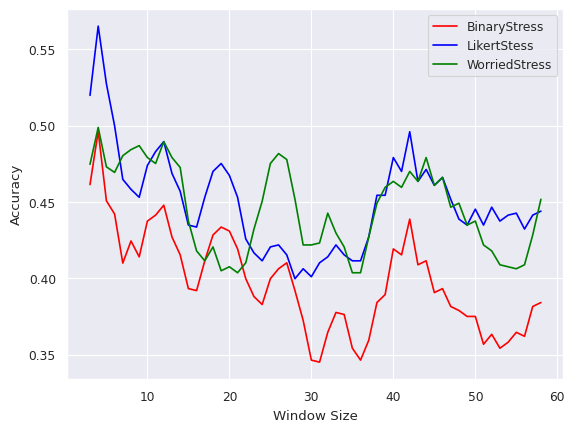

In [53]:
xaxis = range(1, 61)
plotter(xaxis, Bacc, Lacc, Wacc)
dummy1, = plt.plot([], [], '-', color='red', label='BinaryStress')
dummy2, = plt.plot([], [], '-', color='blue', label='LikertStess')
dummy3, = plt.plot([], [], '-', color='green', label='WorriedStress')

legend1 = plt.legend(handles=[dummy1, dummy2, dummy3])
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.savefig('./Plots/avg(1).png')
plt.show()


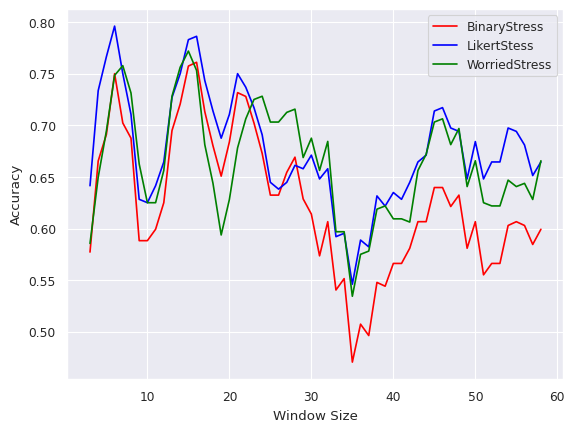

In [54]:
plotter(xaxis, Bacc_stress, Lacc_stress, Wacc_stress)
dummy1, = plt.plot([], [], '-', color='red', label='BinaryStress')
dummy2, = plt.plot([], [], '-', color='blue', label='LikertStess')
dummy3, = plt.plot([], [], '-', color='green', label='WorriedStress')

legend1 = plt.legend(handles=[dummy1, dummy2, dummy3])
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.savefig('./Plots/stress(1).png')
plt.show()


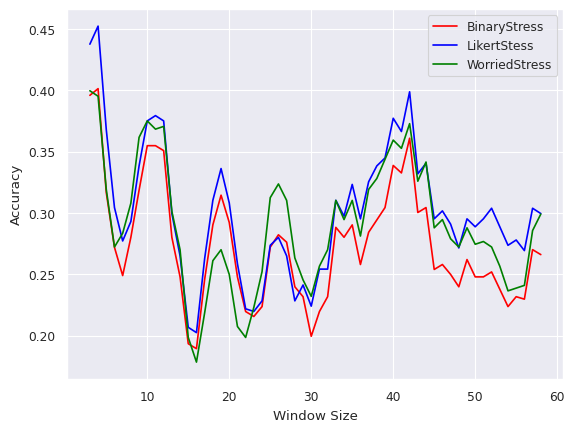

In [55]:
plotter(xaxis, Bacc_nostress, Lacc_nostress, Wacc_nostress)
dummy1, = plt.plot([], [], '-', color='red', label='BinaryStress')
dummy2, = plt.plot([], [], '-', color='blue', label='LikertStess')
dummy3, = plt.plot([], [], '-', color='green', label='WorriedStress')

legend1 = plt.legend(handles=[dummy1, dummy2, dummy3])
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.savefig('./Plots/nostress(1).png')
plt.show()
